
<h1 style="background-color:Gold;" > <style="font-family:verdana;"> <center> Melanoma Image Classification </center> </h1>


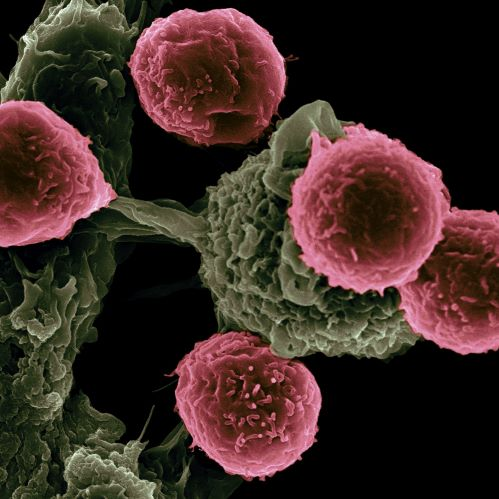

Photo by <a href="https://unsplash.com/@nci?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">National Cancer Institute</a> on <a href="https://unsplash.com/s/photos/cancer?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Unsplash</a>

<h1 style="background-color:Gold; font-family:newtimeroman; font-size:200%; text-align:left;"> Table of Contents </h1>

#### 1. Brief Introduction of Melanoma
#### 2. Problem Statement
#### 3. Import necessary Libraries
#### 4. About the datasets
##### 4.1. Files
#### 5. Load the datasets
##### 5.1.  Preprocessing the Images
##### 5.2.  Autotuning
##### 5.3.  Normalize 
#### 6. Train the Model with CNN
#### 7. Visualize the model performance
#### 8. Boost Model performance with Augmentation
#### 9. Train the model using the augmented images
#### 9. Visualize the augmented model's performance
#### 10.Submit predictions
#### References

<h2 style="background-color:Gold; font-family:newtimeroman; font-size:200%; text-align:left;"> Brief introduction of Melanoma</h2>

The most common form of cancer is skin cancer. Despite being the least prevalent skin cancer, melanoma is responsible for 75 percent of skin cancer deaths. According to the American Cancer Society, over 100,000 new cases of melanoma will be diagnosed in 2020. Nearly 7,000 people are estimated to die as a result of the outbreak. Early and reliable identification, as with other cancers, will improve treatment effectiveness, which could be aided by data science.

Dermatologists currently examine each of a patient's moles to spot outlier lesions or "ugly ducklings" that are most likely to be melanoma. 

<h2 style="background-color:Gold; font-family:newtimeroman; font-size:200%; text-align:left;"> Problem Statement</h2>

Using patient-level contextual knowledge in the creation of image analysis tools to help clinical dermatologists better on how to spot outlier lesions.
The problem is to predict a binary target for each image. The model should predict the probability (floating point) between 0.0 and 1.0 that the lesion in the image is malignant (the target). In the training data, train.csv, the value 0 denotes benign, and 1 indicates malignant.

<h2 style="background-color:Gold; font-family:newtimeroman; font-size:200%; text-align:left;"> Import necessary libraries</h2>

In [63]:
from keras.models import Model, Sequential
from keras.layers import Activation, Dense, BatchNormalization, concatenate, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Input, Reshape
from keras.callbacks import EarlyStopping
from keras.layers.core import SpatialDropout2D
from keras import backend as K
from keras.optimizers import Adam
import tensorflow as tf
import numpy as np
import pandas as pd
import glob
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from warnings import filterwarnings

filterwarnings('ignore')
np.random.seed(101)

In [64]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [65]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

<h2 style="background-color:Gold; font-family:newtimeroman; font-size:200%; text-align:left;"> About the datasets</h2>
​
The datasets was publicly made available by Kaggle but provided by the International Skin Imaging Collaboration (ISIC), funded by the International Society for Digital Imaging of the Skin, is an international initiative to improve melanoma diagnosis (ISDIS). The ISIC Archive houses the world's largest collection of high-resolution dermoscopic photographs of skin lesions. Contributors to the images include:
​
1. Dermatology Service, Melanoma Unit, Hospital Clínic de Barcelona, IDIBAPS, Universitat de Barcelona, Barcelona, Spain
2. Memorial Sloan Kettering Cancer Center New York, NY
3. Department of Dermatology, Medical University of Vienna. Vienna, Austria
4. Melanoma Institute Australia. Sydney, Australia
5. The University of Queensland, Brisbane, Australia
6. Department of Dermatology, University of Athens Medical School
​
It has 9 classes of Skin diseases which are pigmented benign keratosis, melanoma,vascular lesion,actinic keratosis,squamous cell carcinoma,basal cell carcinoma,seborrheic keratosis,dermatofibroma and nevus.
​
Our focus in this Notebook is Melanoma.

<h3 style="background-color:Gold; font-family:newtimeroman; font-size:200%; text-align:left;"> Files</h3>

train.csv - the training set
test.csv - the test set
sample_submission.csv - a sample submission file in the correct format
Columns
image_name - unique identifier, points to filename of related DICOM image
patient_id - unique patient identifier
sex - the sex of the patient (when unknown, will be blank)
age_approx - approximate patient age at time of imaging
anatom_site_general_challenge - location of imaged site
diagnosis - detailed diagnosis information (train only)
benign_malignant - indicator of malignancy of imaged lesion
target - binarized version of the target variable

<h2 style="background-color:Gold; font-family:newtimeroman; font-size:200%; text-align:left;"> Load datasets</h2>

In [66]:
train_path = '../input/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Train'
test_path = '../input/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Test'

<h2 style="background-color:Gold; font-family:newtimeroman; font-size:200%; text-align:left;"> Preprocess the images</h2>

In [67]:
from PIL import Image
import os, sys

path = "../input/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
dirs = os.listdir( path )

def resize():
    for item in dirs:
        if os.path.isfile(path+item):
            im = Image.open(path+item)
            f, e = os.path.splitext(path+item)
            imResize = im.resize((200,200), Image.ANTIALIAS)
            imResize.save(f + ' resized.jpg', 'JPEG', quality=90)

resize()

In [68]:
import pathlib
data_dir = pathlib.Path(train_path)


In [69]:
image_count1 = len(list(data_dir.glob('*/*.jpg')))
print(image_count1)


2239


In [70]:
batch_size = 32
img_height = 180
img_width = 180

In [71]:
classes=['pigmented benign keratosis',
 'melanoma',
 'vascular lesion',
 'actinic keratosis',
 'squamous cell carcinoma',
 'basal cell carcinoma',
 'seborrheic keratosis',
 'dermatofibroma',
 'nevus']

In [72]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [73]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [74]:
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


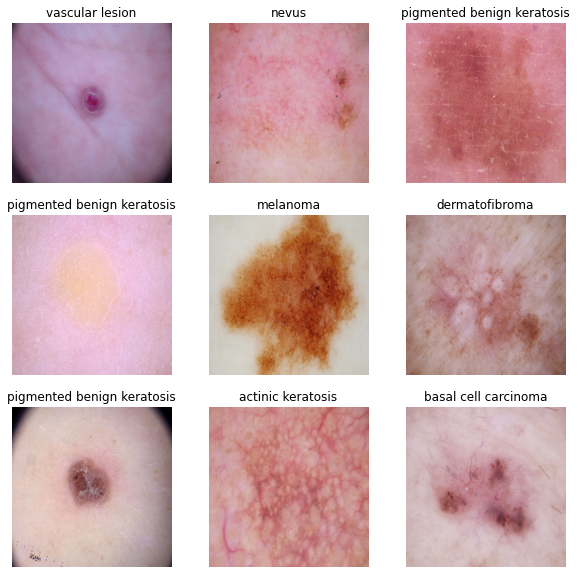

In [75]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [76]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


<h4 style="background-color:Gold; font-family:newtimeroman; font-size:200%; text-align:left;"> Autotune the images</h4>

In [77]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

<h5 style="background-color:Gold; font-family:newtimeroman; font-size:200%; text-align:left;"> Normalize the images</h5>

In [78]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [79]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.07254902 0.87696075


<h2 style="background-color:Gold; font-family:newtimeroman; font-size:200%; text-align:left;"> Train the Model with CNN</h2>

In [80]:
num_classes = 9

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [81]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [82]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_7 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 22, 22, 64)       

In [83]:
epochs=15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
56/56 [==============================] - 34s 601ms/step - loss: 2.0308 - accuracy: 0.2559 - val_loss: 1.7624 - val_accuracy: 0.4318
Epoch 2/15
56/56 [==============================] - 30s 542ms/step - loss: 1.6477 - accuracy: 0.4384 - val_loss: 1.7050 - val_accuracy: 0.3714
Epoch 3/15
56/56 [==============================] - 30s 532ms/step - loss: 1.5033 - accuracy: 0.4699 - val_loss: 1.3565 - val_accuracy: 0.5481
Epoch 4/15
56/56 [==============================] - 30s 539ms/step - loss: 1.2969 - accuracy: 0.5534 - val_loss: 1.3702 - val_accuracy: 0.5481
Epoch 5/15
56/56 [==============================] - 31s 550ms/step - loss: 1.2322 - accuracy: 0.5822 - val_loss: 1.3425 - val_accuracy: 0.5436
Epoch 6/15
56/56 [==============================] - 30s 543ms/step - loss: 1.0931 - accuracy: 0.6247 - val_loss: 1.3905 - val_accuracy: 0.5324
Epoch 7/15
56/56 [==============================] - 30s 542ms/step - loss: 0.9972 - accuracy: 0.6627 - val_loss: 1.4998 - val_accuracy: 0.5235

<h2 style="background-color:Gold; font-family:newtimeroman; font-size:200%; text-align:left;"> Visualize Model Performance</h2>

Using accuracy as the metrics 

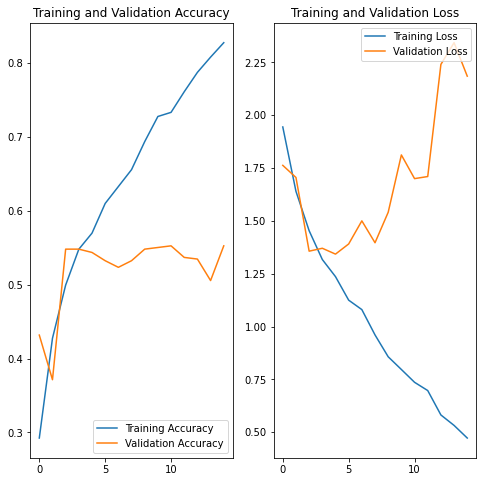

In [84]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

<h2 style="background-color:Gold; font-family:newtimeroman; font-size:200%; text-align:left;"> Boost Model Performance with Augmentation</h2>

As you can see, this has achieved 78%, then we try whether augmentation can boost the model accuracy knowing fully well that we are dealing with small image datasets.

In [85]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

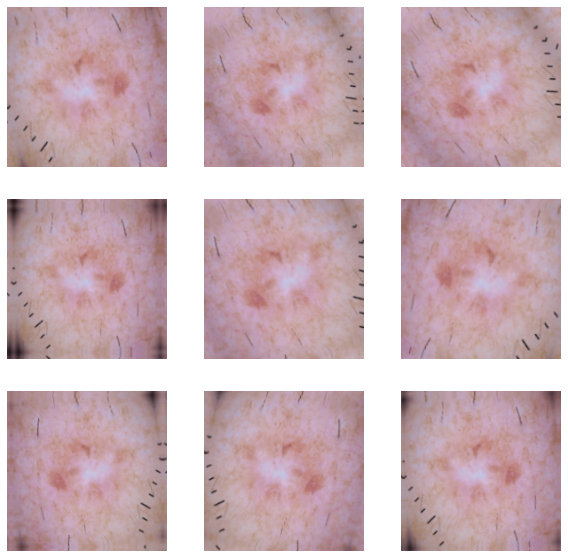

In [86]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

<h2 style="background-color:Gold; font-family:newtimeroman; font-size:200%; text-align:left;"> Train the model using the augmented images</h2>

In [87]:

  aug_model = Sequential([
      data_augmentation,
      layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
      layers.Conv2D(16, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(32, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(64, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Flatten(),
      layers.Dense(128, activation='relu'),
      layers.Dense(num_classes)])

In [88]:
aug_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [89]:
aug_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_7 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_8 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 45, 45, 64)       

In [90]:
epochs = 20
history = aug_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 36s 637ms/step - loss: 1.9469 - accuracy: 0.2667 - val_loss: 1.6793 - val_accuracy: 0.3758
Epoch 2/20
56/56 [==============================] - 35s 624ms/step - loss: 1.6113 - accuracy: 0.4059 - val_loss: 1.5956 - val_accuracy: 0.4519
Epoch 3/20
56/56 [==============================] - 35s 625ms/step - loss: 1.5073 - accuracy: 0.4731 - val_loss: 1.4137 - val_accuracy: 0.5078
Epoch 4/20
56/56 [==============================] - 35s 627ms/step - loss: 1.4130 - accuracy: 0.4942 - val_loss: 1.4059 - val_accuracy: 0.5056
Epoch 5/20
56/56 [==============================] - 35s 623ms/step - loss: 1.3584 - accuracy: 0.5298 - val_loss: 1.3806 - val_accuracy: 0.5302
Epoch 6/20
56/56 [==============================] - 35s 621ms/step - loss: 1.3140 - accuracy: 0.5419 - val_loss: 1.3541 - val_accuracy: 0.5257
Epoch 7/20
56/56 [==============================] - 35s 622ms/step - loss: 1.2738 - accuracy: 0.5568 - val_loss: 1.3216 - val_accuracy: 0.5369

<h2 style="background-color:Gold; font-family:newtimeroman; font-size:200%; text-align:left;"> Visualize the accuracy</h2>
The accuracy results keeps changing because of the randomly picked training data👌 
This also clearly indicates that sizes matters when training a model, so that the model can picked randomly from the available image dataset.

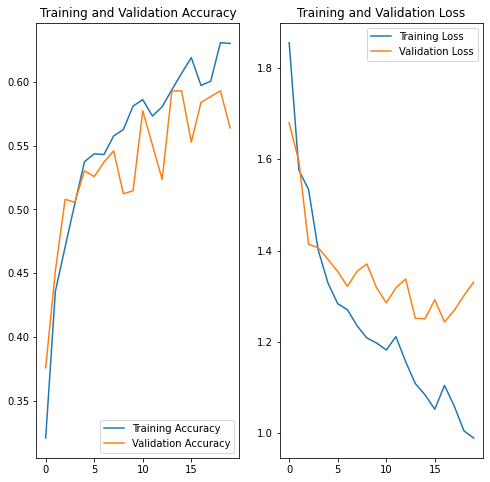

In [91]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

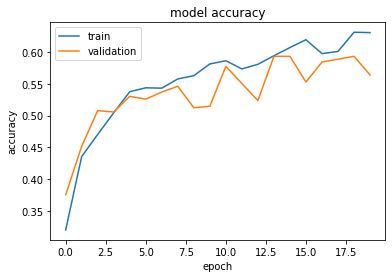

In [92]:
# Plotting Model accuracy

def plot_history(history):
    plt.plot(history.history["accuracy"])
    plt.plot(history.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_history(history)

<h2 style="background-color:Gold; font-family:newtimeroman; font-size:200%; text-align:left;"> Make predictions</h2>

In [93]:

val_images_ds = val_ds.map(lambda image, idnum: image)
probabilities = model.predict(val_images_ds)
print('Predictions...')

Predictions...


In [94]:
probabilities[:,4] 

array([ 8.89962077e-01,  8.28438282e+00,  2.85116839e+00, -1.26540422e+00,
        3.28493309e+00,  1.29737635e+01,  7.05004454e-01,  1.62686312e+00,
        1.04970293e+01, -1.60593897e-01,  1.03135376e+01,  5.08796883e+00,
        5.40884876e+00, -1.90802254e-02,  1.89909410e+00,  2.67101496e-01,
        9.65164125e-01,  9.37768173e+00,  1.78090744e+01,  8.50514698e+00,
        2.80317813e-01,  8.70036602e+00, -7.13582397e-01,  1.73617733e+00,
        2.67045259e+00,  1.56772459e+00,  5.26912570e-01,  4.31808424e+00,
       -1.68954659e+00,  7.90050030e+00,  1.19678214e-01,  3.27390218e+00,
        9.91239738e+00,  4.33297729e+00,  4.26679134e+00,  4.36452055e+00,
        7.82336950e-01,  1.04151926e+01,  4.91458988e+00,  5.07314444e+00,
        2.94975924e+00,  1.14467096e+01,  1.75462937e+00,  4.91463304e-01,
        6.58714235e-01,  1.48069639e+01,  4.30619574e+00,  3.01428437e+00,
        2.26342082e+00,  8.05716813e-01,  4.50566339e+00, -2.37412167e+00,
       -1.58697748e+00, -

In [95]:
probabilities[0,:].shape

(9,)

In [96]:
import numpy as np
from keras.preprocessing import image

img_width, img_height = 200, 200
img = image.load_img('../input/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Test/melanoma/ISIC_0000002.jpg', target_size = (img_width, img_height))
img = image.img_to_array(img)
img = np.expand_dims(img, axis = 0)

aug_model.predict(img)

ValueError: in user code:

    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1478 predict_function  *
        return step_function(self, iterator)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1468 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1461 run_step  **
        outputs = model.predict_step(data)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1434 predict_step
        return self(x, training=False)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:1012 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:375 call
        return super(Sequential, self).call(inputs, training=training, mask=mask)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/functional.py:425 call
        inputs, training=training, mask=mask)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/functional.py:560 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/input_spec.py:259 assert_input_compatibility
        ' but received input with shape ' + display_shape(x.shape))

    ValueError: Input 0 of layer dense_10 is incompatible with the layer: expected axis -1 of input shape to have value 30976 but received input with shape (None, 40000)


<h2 style="background-color:Gold; font-family:newtimeroman; font-size:200%; text-align:left;"> Submit predictions</h2>

<h2 style="background-color:Gold; font-family:newtimeroman; font-size:200%; text-align:left;"> References</h2>

* Photo by National Cancer Institute on Unsplash

* The ISIC 2020 Challenge Dataset https://doi.org/10.34970/2020-ds01 (c) by ISDIS, 2020

* Creative Commons Attribution-Non Commercial 4.0 International License.

The dataset was generated by the International Skin Imaging Collaboration (ISIC) and images are from the following sources: Hospital Clínic de Barcelona, Medical University of Vienna, Memorial Sloan Kettering Cancer Center, Melanoma Institute Australia, The University of Queensland, and the University of Athens Medical School.

* https://www.kaggle.com/shubhamksingh/create-beautiful-notebooks-formatting-tutorial